In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torchvision 
import torch 
from torch.utils.data import random_split
import torch.nn as nn 
import torch.nn.functional as F 
import os
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

In [109]:
data_dir  = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'
transformations = transforms.Compose([transforms.Resize((256, 256)),
                                      transforms.RandomAffine(45),
                                      transforms.RandomHorizontalFlip(p=0.3),
                                      transforms.ToTensor(),
                                     transforms.Normalize(mean=(0.5,0.5,0.5),std=(0.5,0.5,0.5))])
dataset = ImageFolder(data_dir, transform = transformations)
classes = os.listdir(data_dir)
print(classes)

['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic']


# Data Augmentation

In [132]:
transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

plot_dataset = ImageFolder(data_dir, transform = transformations)


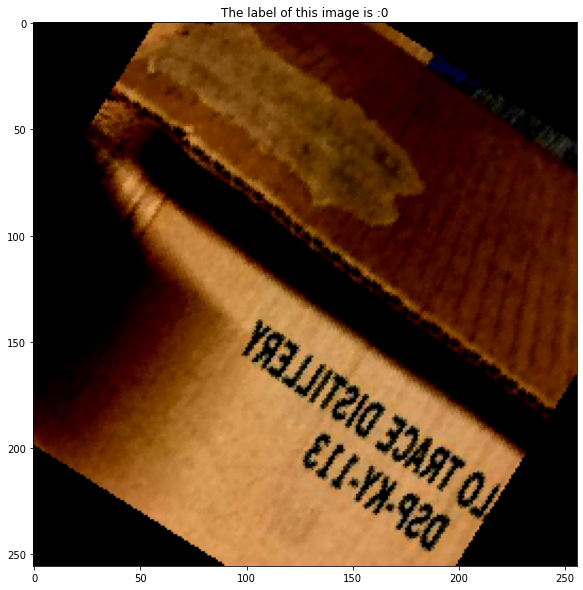

In [149]:
ax,fig = plt.subplots(figsize=(10,10))
plot_dataset =ImageFolder(data_dir,transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor()]))
plt.imshow(dataset[12][0].permute(1,2,0))
plt.title(f"The label of this image is :{int(dataset[12][1])}")
plt.show()

In [111]:
train_length= int(len(dataset)*0.8)
# val_length= int(len(dataset)*0.2)
test_length = len(dataset)- train_length

In [112]:
train,test = random_split(dataset,[train_length,test_length])

In [113]:
batch_size = 32
train_dl = DataLoader(train,batch_size,shuffle=True,num_workers=4,pin_memory=True)
# val_dl = DataLoader(val,batch_size,shuffle=True,num_workers=4,pin_memory=True)
test_dl= DataLoader(test,batch_size,shuffle=True,num_workers=4,pin_memory=True)

# Training data on Resnet50 
> Resnet50 is a pretrained 50 layers deep CNN available in Pytorch. It finds an optimal number of layers which negates the Vanishing Gradient problem. It tries to learn the residuals of the predictions until the output matches the actual value.

In [114]:
class Resnet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnet= torchvision.models.resnet50(pretrained=True)
        num_ftrs = self.rnet.fc.in_features
        self.rnet.fc = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(num_ftrs, out_features=len(classes))
        )
    
    def forward(self,x):
        x= self.rnet(x)
        return x
        
        
        

In [115]:
model = Resnet50()

In [116]:
# model

In [117]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [118]:
epochs=8
for e in range(epochs):
    running_loss = 0
    total = 0
    batch_size = 32
    
    for i,(images,labels) in enumerate(train_dl):
        
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            model.cuda()
            
        
        optimizer.zero_grad()
        output = model(images)
        loss = F.cross_entropy(output,labels)
        loss.backward() # Backward Propogation
        optimizer.step()
        running_loss += loss.item()
        
    print("Epoch{} - Training Loss: {}".format(e+1,running_loss/len(train_dl)))
    

Epoch1 - Training Loss: 0.807419718708843
Epoch2 - Training Loss: 0.2857913044281304
Epoch3 - Training Loss: 0.21303785196505487
Epoch4 - Training Loss: 0.16724847929435782
Epoch5 - Training Loss: 0.16491947646136396
Epoch6 - Training Loss: 0.11277508112834767
Epoch7 - Training Loss: 0.086988128896337
Epoch8 - Training Loss: 0.07476816200141911


In [119]:
model.eval()
correct=0
total=0
predictions = torch.tensor([]).cuda()
labels_ = torch.tensor([]).cuda()
images_ = torch.tensor([]).cuda()

for images,labels in test_dl:
    
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()
        model.cuda()
        
    output= model(images)
    _,pred = torch.max(output.data,1)
    loss = F.cross_entropy(output, labels)
    correct += pred.eq(labels.data).sum().item()
    total += labels.size(0)
    predictions= torch.cat((pred,predictions))
    labels_ = torch.cat((labels,labels_))
    images_ = torch.cat((images,images_))
    

    
print(f"The accuracy of the model is {np.round(correct/total*100,2)}% \
      with Loss: {loss}")
    

The accuracy of the model is 93.28%       with Loss: 0.17071384191513062


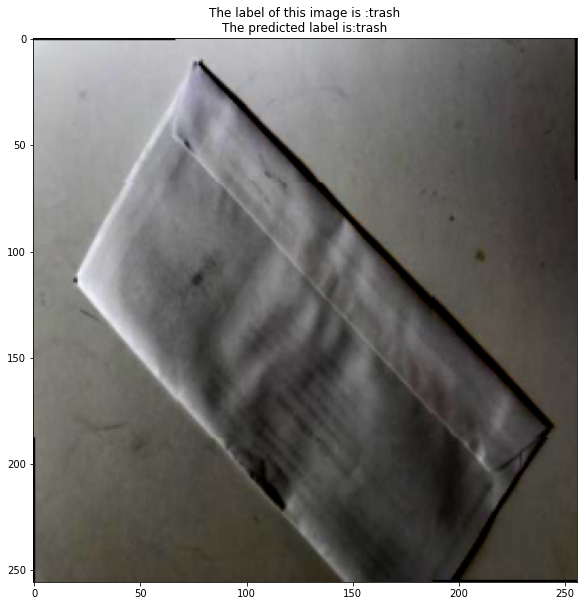

In [146]:
ax,fig = plt.subplots(figsize=(10,10))
plt.imshow(images_[3].cpu().permute(1,2,0))
plt.title(f"The label of this image is :{classes[int(labels_[3])]}\nThe predicted label is:{classes[int(predictions[3])]}")
plt.show()

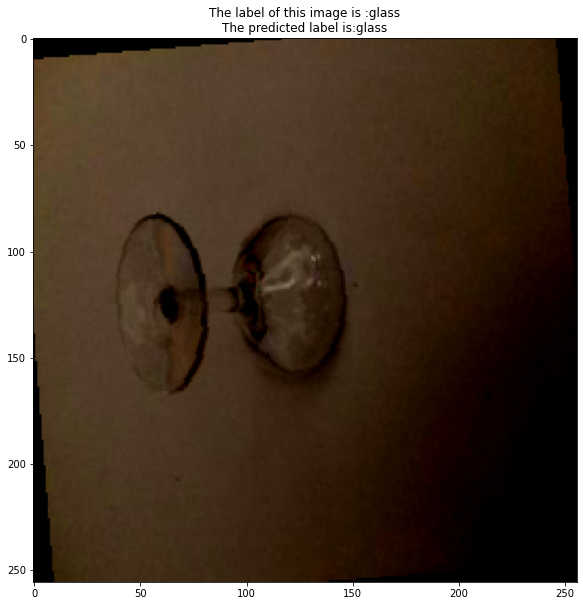

In [147]:
ax,fig = plt.subplots(figsize=(10,10))
plt.imshow(images_[9].cpu().permute(1,2,0))
plt.title(f"The label of this image is :{classes[int(labels_[9])]}\nThe predicted label is:{classes[int(predictions[9])]}")
plt.show()

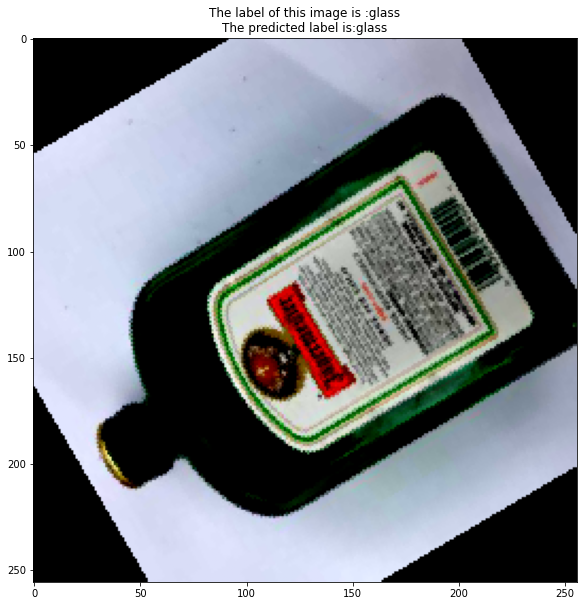

In [148]:
ax,fig = plt.subplots(figsize=(10,10))
plt.imshow(images_[10].cpu().permute(1,2,0))
plt.title(f"The label of this image is :{classes[int(labels_[10])]}\nThe predicted label is:{classes[int(predictions[10])]}")
plt.show()